Loading data from: ../dados/raw/PETR4.SA.csv

Data range: from 2005-01-03 00:00:00 to 2024-11-29 00:00:00

Training model...

Predicting 1 days ahead (future):
Evaluation metrics:
MSE: 0.0087
MAE: 0.0931
RMSE: 0.0931
MAPE: nan


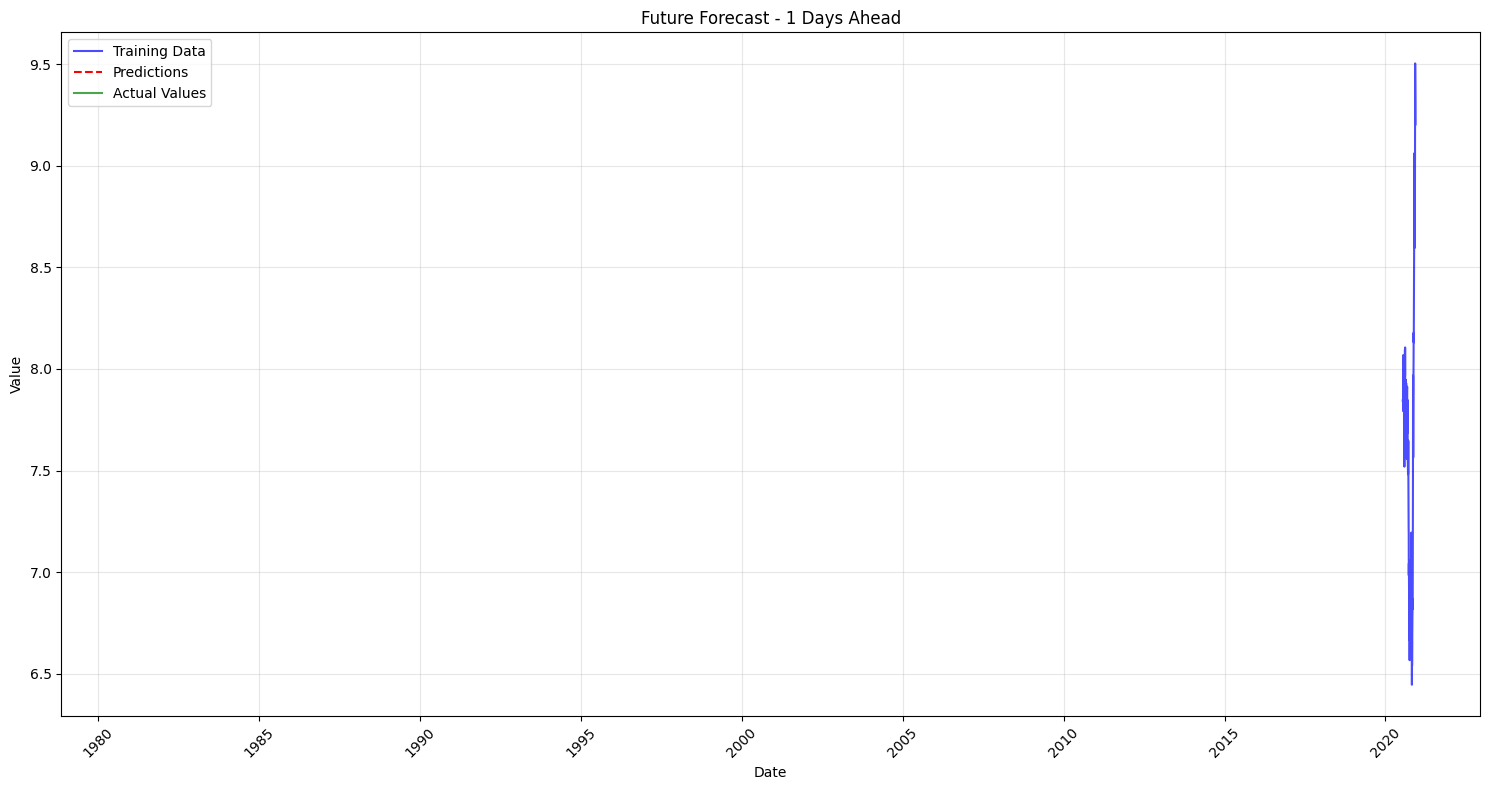


Predicting 5 days ahead (future):
Evaluation metrics:
MSE: 0.0987
MAE: 0.2953
RMSE: 0.3142
MAPE: nan


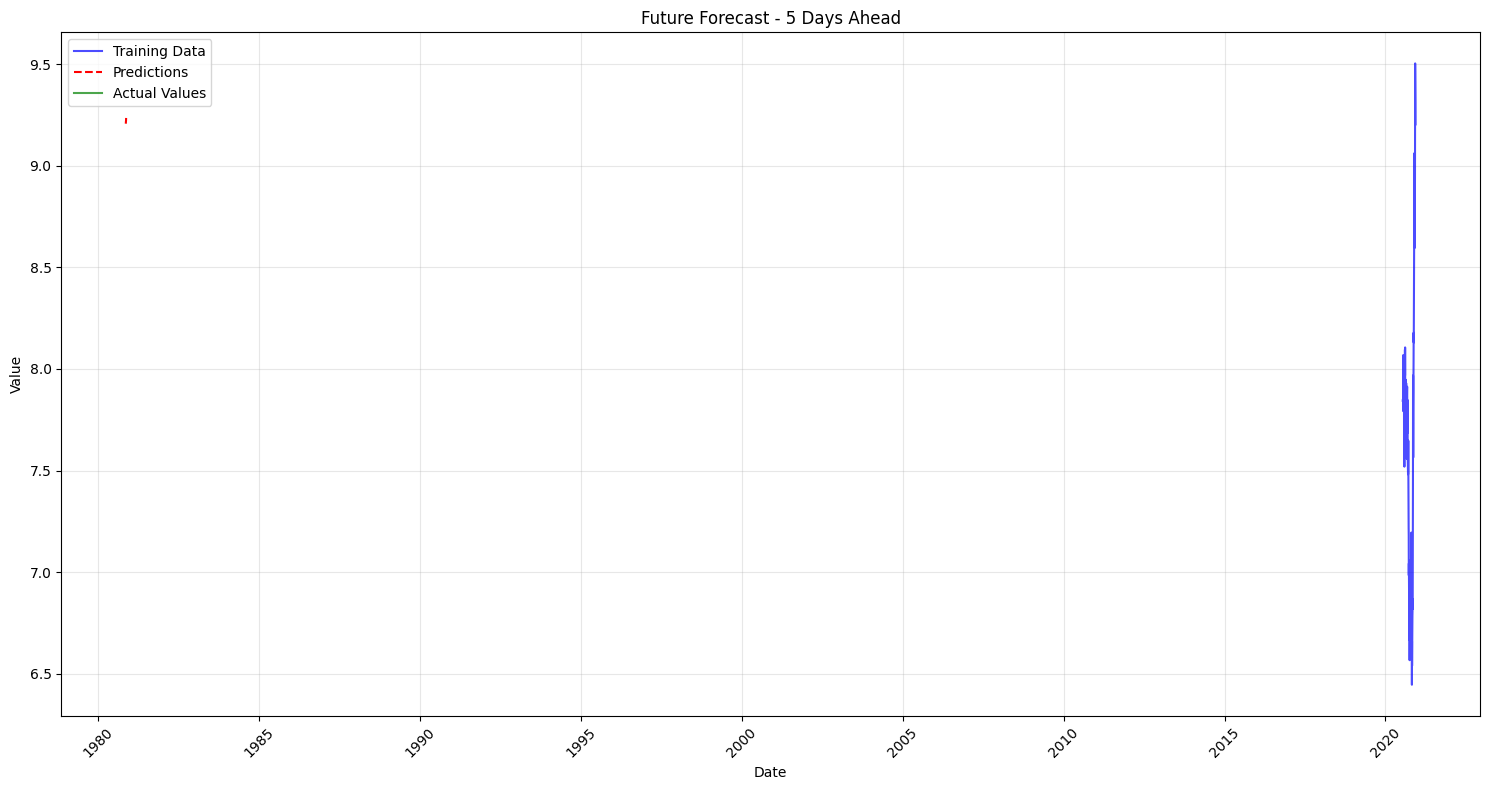


Predicting 7 days ahead (future):
Evaluation metrics:
MSE: 0.1461
MAE: 0.3578
RMSE: 0.3822
MAPE: nan


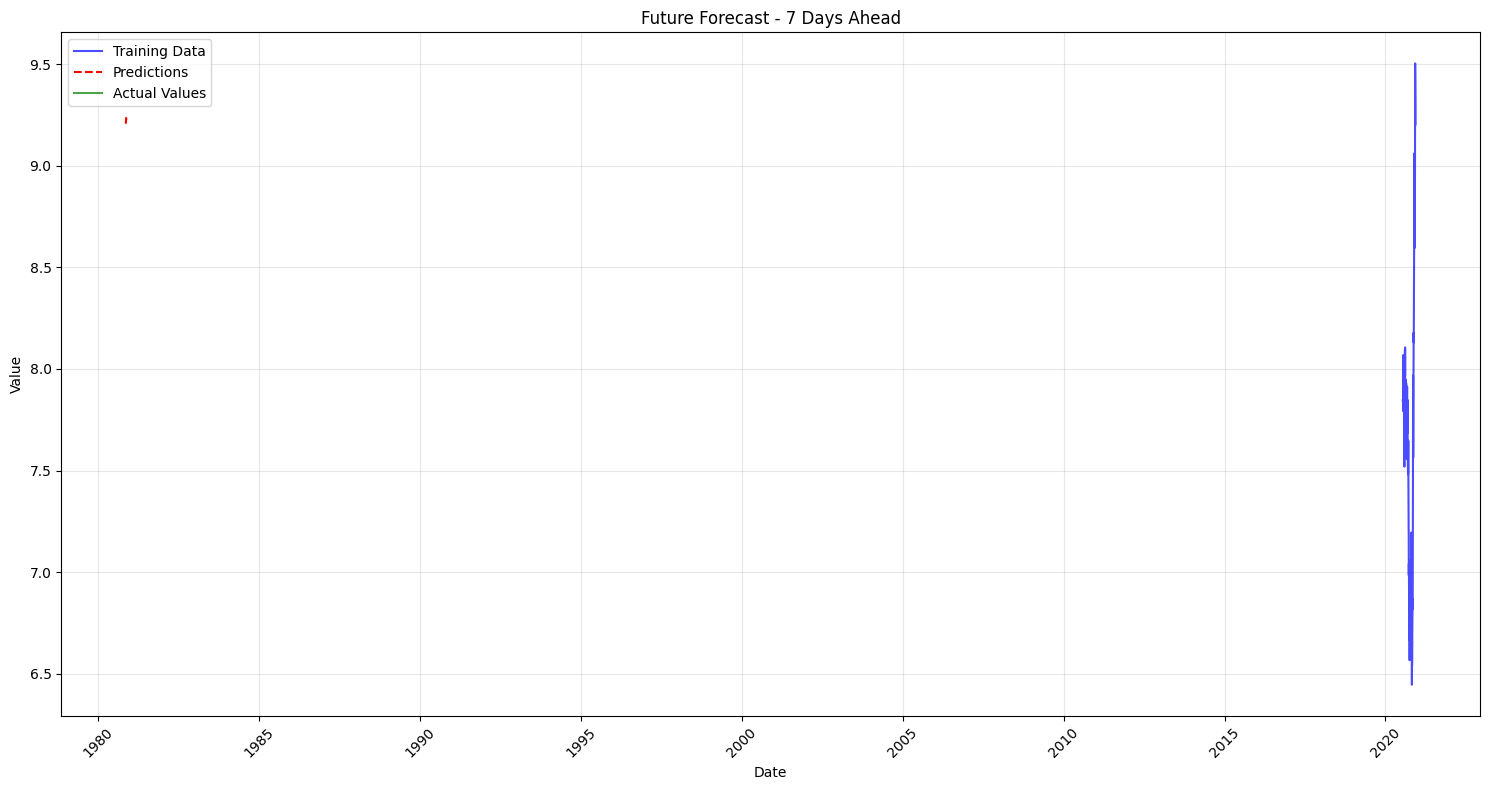


Predicting 15 days ahead (future):
Evaluation metrics:
MSE: 0.1863
MAE: 0.3963
RMSE: 0.4316
MAPE: nan


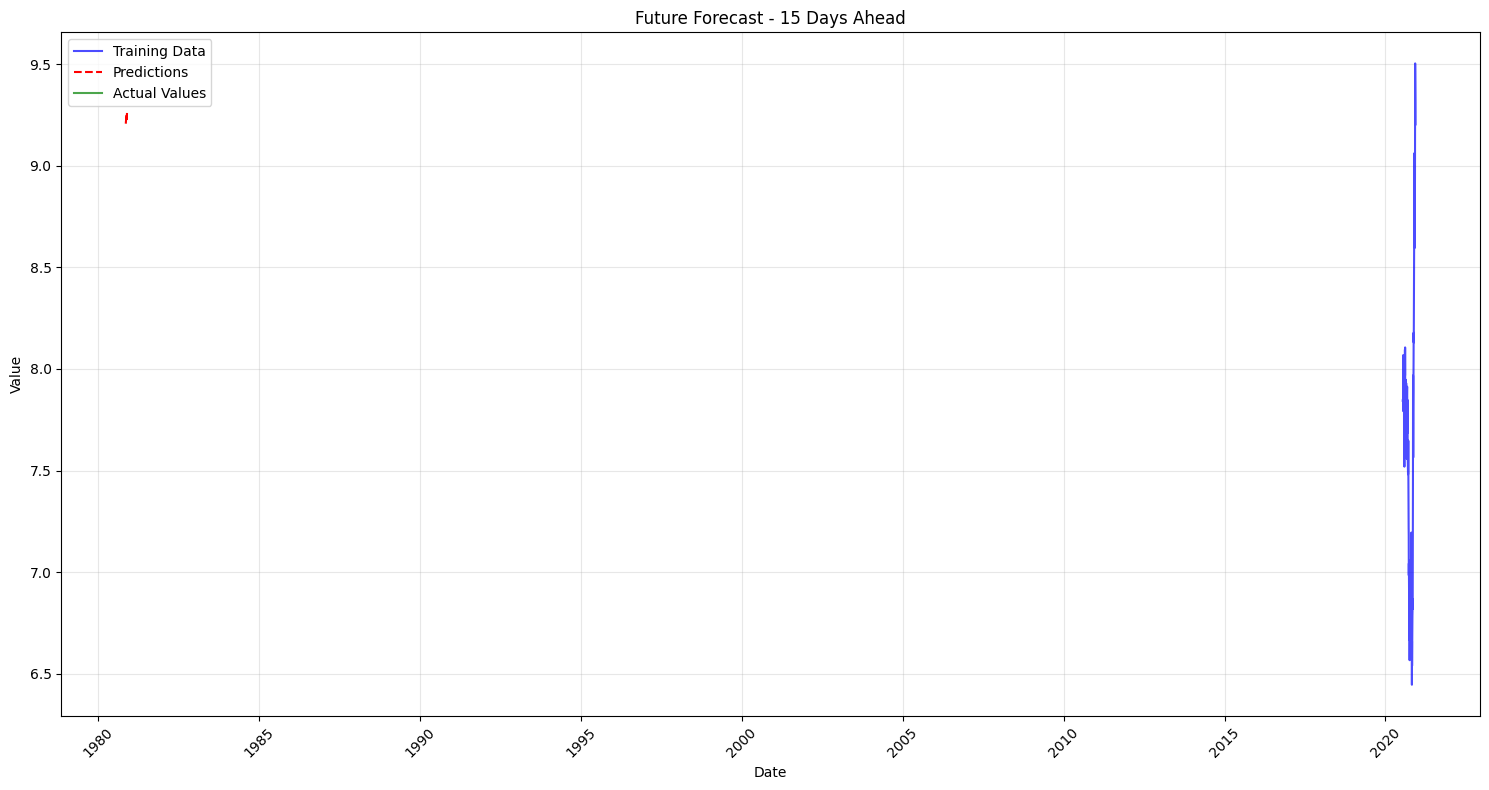


Predicting 30 days ahead (future):
Evaluation metrics:
MSE: 0.5279
MAE: 0.5949
RMSE: 0.7265
MAPE: nan


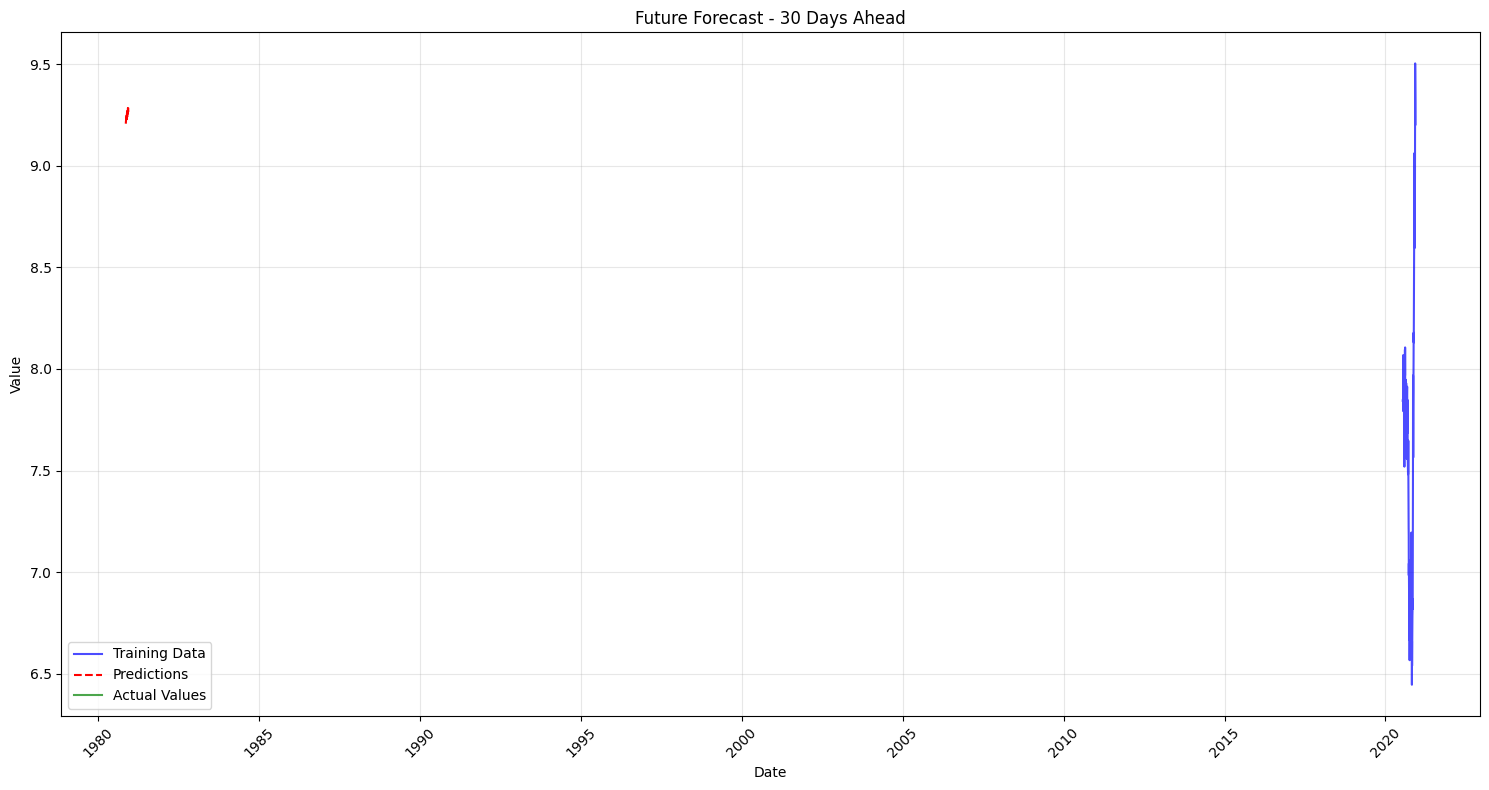


Backtesting dates:
Index 2477: 2014-12-16
Index 2972: 2016-12-19
Index 3467: 2018-12-07

Backtesting from 2014-12-16 (index 2477):


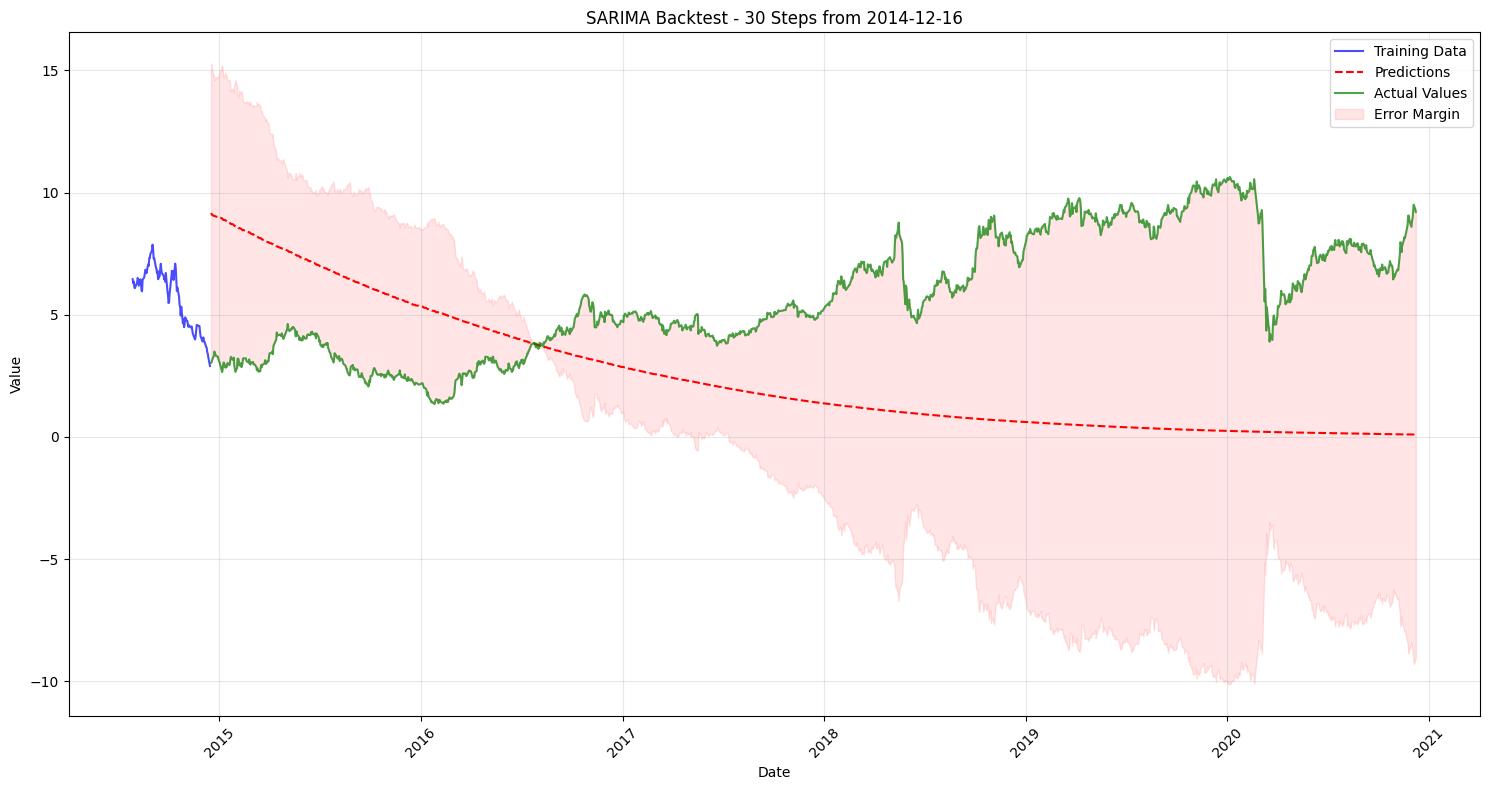

Backtest metrics:
MSE: 32.5401
MAE: 5.0084
RMSE: 5.7044
MAPE: 89.1495

Backtesting from 2016-12-19 (index 2972):


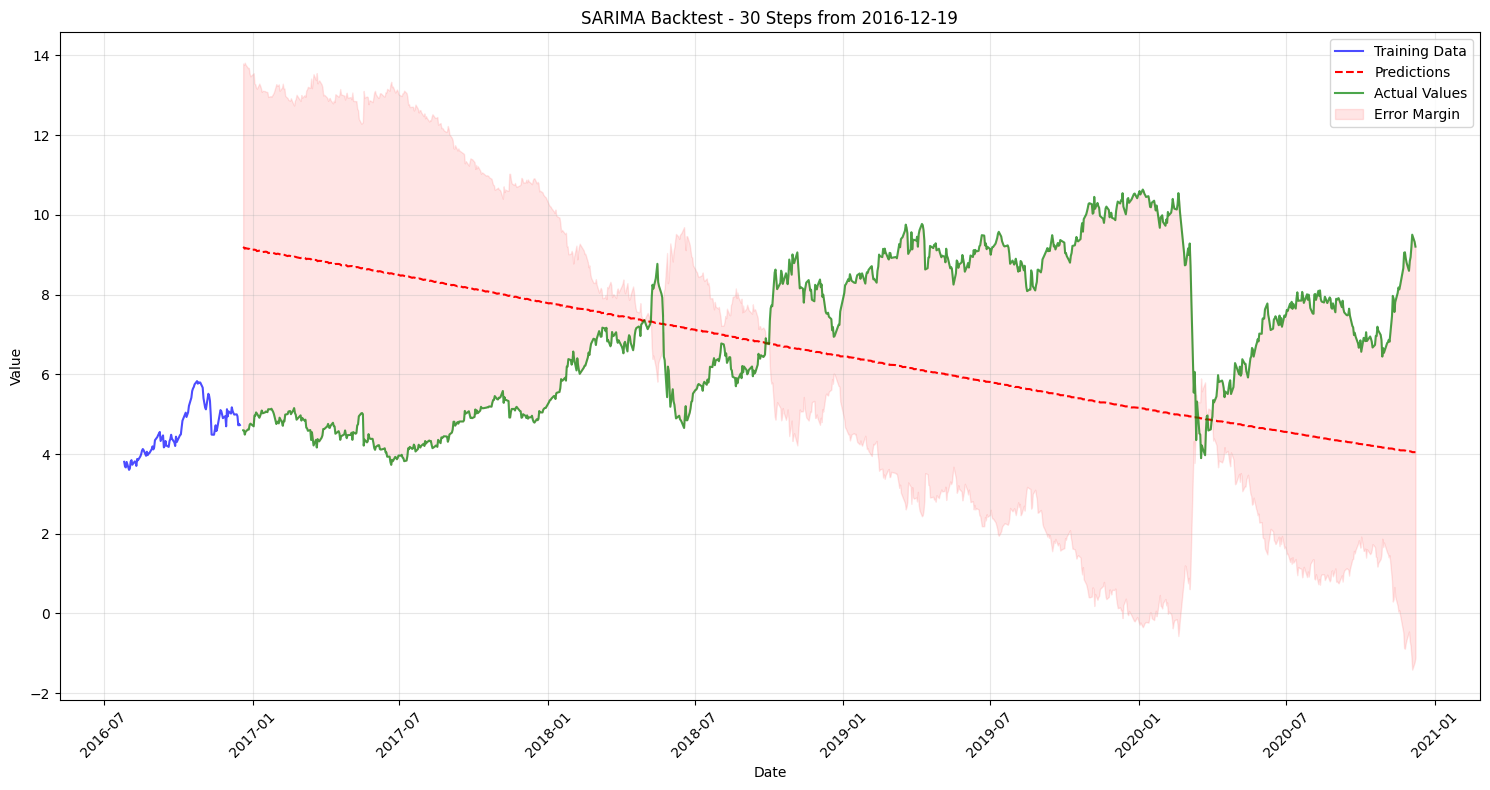

Backtest metrics:
MSE: 10.1024
MAE: 2.8569
RMSE: 3.1784
MAPE: 44.4783

Backtesting from 2018-12-07 (index 3467):


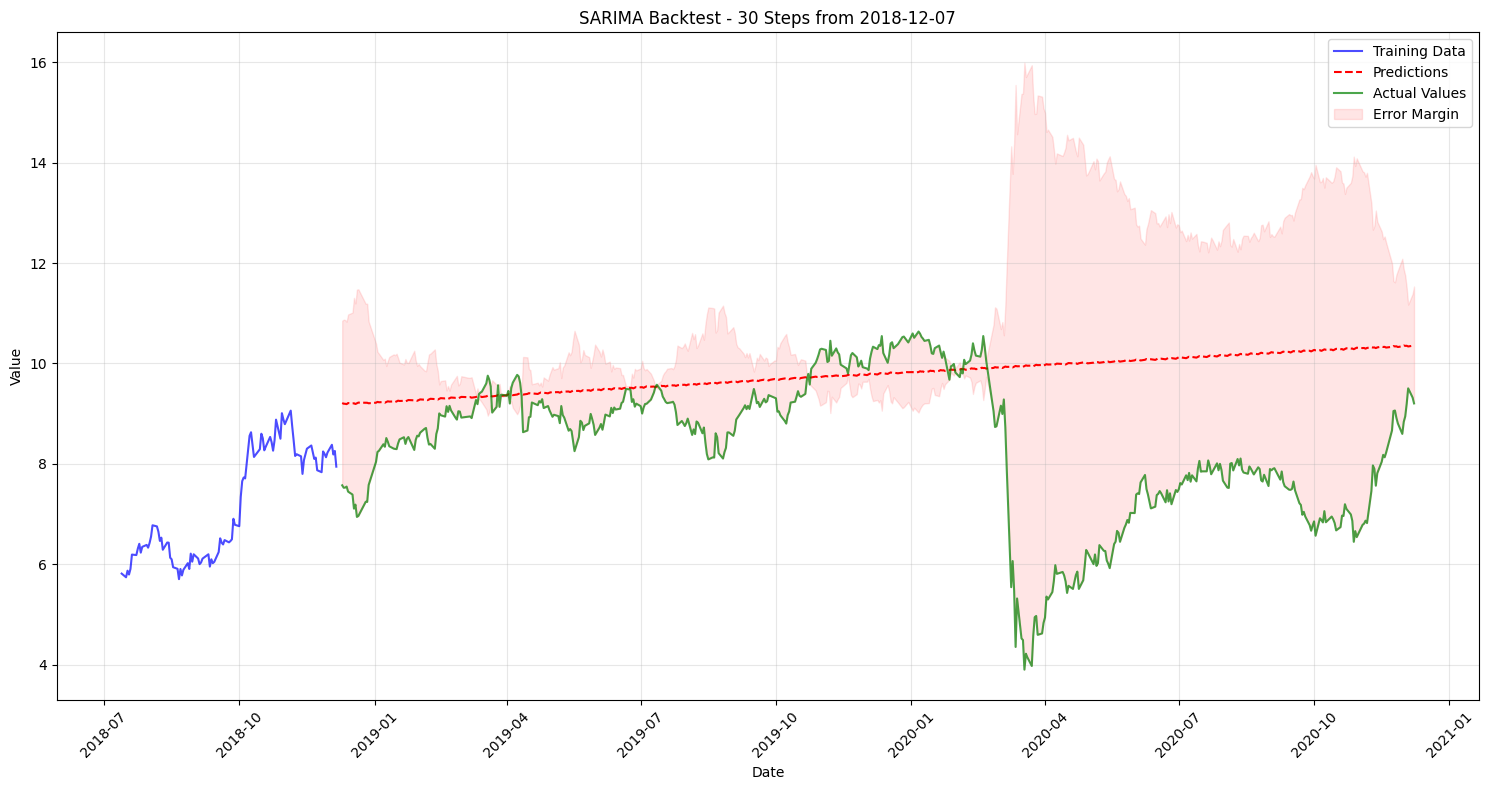

Backtest metrics:
MSE: 4.4612
MAE: 1.5504
RMSE: 2.1122
MAPE: 22.7170


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

class SARIMAModel:
    def __init__(self, order: Tuple[int, int, int] = (2, 1, 2),
                 seasonal_order: Tuple[int, int, int, int] = (1, 1, 1, 5)):
        """
        Initialize SARIMA model with specified parameters
        
        Args:
            order: ARIMA order (p, d, q)
            seasonal_order: Seasonal order (P, D, Q, s)
        """
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None
        self.fitted_model = None
        
    def check_stationarity(self, data: pd.Series) -> Tuple[bool, pd.Series]:
        """
        Check if the time series is stationary using ADF test and make it stationary if needed
        
        Args:
            data: Time series data
            
        Returns:
            Tuple of (is_stationary, transformed_data)
        """
        # Primeira verificação
        result = adfuller(data.values)
        is_stationary = result[1] < 0.05
        
        if is_stationary:
            return True, data
            
        # Tenta diferenciação
        diff_data = data.diff().dropna()
        result = adfuller(diff_data.values)
        is_stationary = result[1] < 0.05
        
        if is_stationary:
            print("Series became stationary after first difference")
            return True, diff_data
            
        # Tenta diferenciação de segunda ordem
        diff2_data = diff_data.diff().dropna()
        result = adfuller(diff2_data.values)
        is_stationary = result[1] < 0.05
        
        if is_stationary:
            print("Series became stationary after second difference")
            return True, diff2_data
            
        print("Warning: Series remains non-stationary even after transformations")
        return False, data
    
    def load_data(self, file_path: str, target_column: str = 'Adj Close') -> pd.DataFrame:
        """
        Load and prepare time series data
        
        Args:
            file_path: Path to the CSV file
            target_column: Column to be used for predictions
            
        Returns:
            Processed DataFrame with datetime index
        """
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        return df[target_column]
    
    def prepare_data(self, data: pd.Series) -> pd.Series:
        """
        Prepare data for SARIMA modeling by applying necessary transformations
        
        Args:
            data: Original time series data
            
        Returns:
            Transformed time series data
        """
        # Apply returns transformation
        data_returns = np.log(data / data.shift(1)).dropna()
        
        # Check stationarity and apply additional transformations if needed
        is_stationary, transformed_data = self.check_stationarity(data_returns)
        
        return transformed_data
    
    def inverse_transform(self, data: pd.Series, original_data: pd.Series) -> pd.Series:
        """
        Inverse transform the predictions back to original scale
        
        Args:
            data: Transformed predictions
            original_data: Original data series for reference
            
        Returns:
            Predictions in original scale
        """
        # Get the last value from the original data
        last_value = original_data.iloc[-1]
        
        # Convert from returns to prices
        predicted_prices = last_value * np.exp(data.cumsum())
        
        return predicted_prices
    
    def train(self, data: pd.Series):
        """
        Train the SARIMA model
        
        Args:
            data: Time series data for training
        """
        # Store original data for inverse transform
        self.original_data = data
        
        # Prepare data
        prepared_data = self.prepare_data(data)
        
        # Create and fit model with more robust parameters
        self.model = SARIMAX(
            prepared_data,
            order=self.order,
            seasonal_order=self.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        self.fitted_model = self.model.fit(
            disp=False,
            maxiter=1000,
            method='lbfgs'
        )
        
    def predict(self, n_steps: int, start_idx: Optional[int] = None) -> pd.Series:
        """
        Make predictions for n steps ahead
        
        Args:
            n_steps: Number of steps to forecast
            start_idx: Optional start index for in-sample predictions
            
        Returns:
            Series with predictions
        """
        if self.fitted_model is None:
            raise ValueError("Model must be trained before making predictions")
        
        if start_idx is not None:
            # In-sample prediction
            forecast = self.fitted_model.get_prediction(start=start_idx, dynamic=True)
            predictions = forecast.predicted_mean
        else:
            # Out-of-sample forecast
            forecast = self.fitted_model.forecast(steps=n_steps)
            predictions = forecast
        
        # Transform predictions back to original scale
        return self.inverse_transform(predictions, self.original_data)
    
    def evaluate(self, y_true: pd.Series, y_pred: pd.Series) -> dict:
        """
        Evaluate model performance
        
        Args:
            y_true: Actual values
            y_pred: Predicted values
            
        Returns:
            Dictionary with evaluation metrics
        """
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        return {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        }
    
    def plot_predictions(self, train_data: pd.Series, predictions: pd.Series,
                        test_data: Optional[pd.Series] = None, title: str = None):
        """
        Plot the training data, predictions and test data if available
        
        Args:
            train_data: Training data
            predictions: Model predictions
            test_data: Test data (optional)
            title: Custom title for the plot
        """
        fig = plt.figure(figsize=(15, 8))
        
        # Plot training data
        plt.plot(train_data.index[-100:], train_data.values[-100:], 
                label='Training Data', color='blue', alpha=0.7)
        
        # Plot predictions
        plt.plot(predictions.index, predictions.values, 
                label='Predictions', color='red', linestyle='--')
        
        if test_data is not None:
            # Ensure we're only plotting test data for the prediction period
            test_period = test_data[predictions.index[0]:predictions.index[-1]]
            plt.plot(test_period.index, test_period.values, 
                    label='Actual Values', color='green', alpha=0.7)
            
            # Add error bands only if we have matching predictions and test data
            if len(predictions) == len(test_period):
                error = np.abs(predictions - test_period)
                plt.fill_between(predictions.index,
                               predictions - error,
                               predictions + error,
                               color='red', alpha=0.1,
                               label='Error Margin')
        
        plt.title(title or 'SARIMA Time Series Forecast')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Show and close the figure properly
        plt.show()
        plt.close(fig)

    def backtest(self, data: pd.Series, start_idx: int, n_steps: int):
        """
        Perform backtesting starting from a specific index
        
        Args:
            data: Complete time series data
            start_idx: Start index for backtesting
            n_steps: Number of steps to forecast
        """
        # Get predictions
        predictions = self.predict(n_steps, start_idx=start_idx)
        
        # Get actual values for the same period
        actual_values = data[predictions.index]
        
        # Calculate metrics
        metrics = self.evaluate(actual_values, predictions)
        
        # Get the date for the title
        start_date = data.index[start_idx].strftime('%Y-%m-%d')
        
        # Plot results
        self.plot_predictions(
            train_data=data[:start_idx],
            predictions=predictions,
            test_data=actual_values,
            title=f'SARIMA Backtest - {n_steps} Steps from {start_date}'
        )
        
        return predictions, actual_values, metrics

def main():
    # Get the absolute path to the script's directory
    #script_dir = os.path.dirname(os.path.abspath(__file__))
    #project_root = os.path.dirname(script_dir)
    #file_path = os.path.join(project_root, 'dados', 'raw', 'PETR4.SA.csv')
    file_path = '../dados/raw/PETR4.SA.csv'

    print(f"Loading data from: {file_path}")
    
    # Initialize model with better parameters for financial data
    model = SARIMAModel(
        order=(2, 1, 2),           # (p, d, q) - Aumentei a ordem para capturar mais padrões
        seasonal_order=(1, 1, 1, 5) # (P, D, Q, s) - Período sazonal menor para dados financeiros
    )
    
    # Load data
    data = model.load_data(file_path)
    
    # Print data range
    print(f"\nData range: from {data.index.min()} to {data.index.max()}")
    
    # Split data into train and test
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # Train model
    print("\nTraining model...")
    model.train(train_data)
    
    # 1. Future predictions
    prediction_horizons = [1, 5, 7, 15, 30]
    for horizon in prediction_horizons:
        print(f"\nPredicting {horizon} days ahead (future):")
        predictions = model.predict(horizon)
        
        if horizon <= len(test_data):
            metrics = model.evaluate(test_data[:horizon], predictions)
            print("Evaluation metrics:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")
        
        model.plot_predictions(
            train_data, 
            predictions, 
            test_data[:horizon] if horizon <= len(test_data) else None,
            title=f'Future Forecast - {horizon} Days Ahead'
        )
    
    # 2. Backtesting (in-sample predictions)
    # Get indices for backtesting
    total_days = len(data)
    backtest_indices = [
        int(total_days * 0.5),  # Middle of the dataset
        int(total_days * 0.6),  # 60% through the dataset
        int(total_days * 0.7)   # 70% through the dataset
    ]
    
    # Print the actual dates we'll use for backtesting
    print("\nBacktesting dates:")
    for idx in backtest_indices:
        print(f"Index {idx}: {data.index[idx].strftime('%Y-%m-%d')}")
    
    for start_idx in backtest_indices:
        date = data.index[start_idx].strftime('%Y-%m-%d')
        print(f"\nBacktesting from {date} (index {start_idx}):")
        predictions, actuals, metrics = model.backtest(data, start_idx, n_steps=30)
        
        print("Backtest metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

if __name__ == "__main__":
    main() 